In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from xgboost import XGBClassifier

sns.set_style("whitegrid") # stile per i grafici

/Users/ashura/Documents/GitHub/Anzellotti_DepositoCorso/.venv/bin/python


# IMPORT DATASET

In [44]:
data = load_breast_cancer()

df = pd.DataFrame(data.data, columns=data.feature_names)

X = df.values
y = data.target

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Info

In [45]:
print("Shape del dataset:", X.shape)

print("\n--- Info ---")
print(df.info())

print("\n--- Descrizione ---")
print(df.describe())

print("\n--- Numero valori nulli ---")
print(df.isnull().sum())

Shape del dataset: (569, 30)

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null

Niente pulizia

# FUNZIONE PER VALUTARE UN MODELLO CON K-FOLD / SRATIFIED K-FOLD

- Esegue cross-validation con folds definiti da cv (KFold o StratifiedKFold)
- Scala le features in ogni fold, allena il modello, e ritorna mean e std dell'accuracy.

Parametri:
- model -> il modello da valutare (LogisticRegression, KNN)
- X -> il dataset (solo features)
- y -> le etichette
- cv -> l’oggetto che gestisce i fold -> KF o SKF

In [46]:
def evaluate_model(model, X, y, cv):
    scores = []
    scores_mse = []
    
    for train_idx, test_idx in cv.split(X, y): # cv.split(X, y) produce tanti split quante sono le folds
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Scaling sulle X
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Training
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        scores.append(accuracy_score(y_test, predictions))
        scores_mse.append(mean_squared_error(y_test, predictions))
        
    
    return np.mean(scores), np.std(scores), np.mean(scores_mse), np.sqrt(np.mean(scores_mse))

# DEFINIZIONE K-FOLD E STRATIFIED K-FOLD

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# LOGISTIC REGRESSION

In [48]:
logreg = LogisticRegression(max_iter=5000)
logreg_results = []

log_kf_mean, log_kf_std, log_kf_mse, log_kf_rmse = evaluate_model(logreg, X, y, kf)
log_skf_mean, log_skf_std, log_skf_mse, log_skf_rmse = evaluate_model(logreg, X, y, skf)

logreg_results.append({
    "KF_mean": log_kf_mean,
    "KF_std": log_kf_std,
    "KF_MSE": log_kf_mse,
    "KF_RMSE": log_kf_rmse,
    "SKF_mean": log_skf_mean,
    "SKF_std": log_skf_std,
    "SKF_MSE": log_skf_mse,
    "SKF_RMSE": log_skf_rmse
})
                      
df_logreg = pd.DataFrame(logreg_results)

print("\nRisultati Logistic Regression:")
display(df_logreg.style.hide(axis="index"))


Risultati Logistic Regression:


KF_mean,KF_std,KF_MSE,KF_RMSE,SKF_mean,SKF_std,SKF_MSE,SKF_RMSE
0.977146,0.008964,0.022854,0.151174,0.973669,0.016627,0.026331,0.162269


# KNN -> KF e SKF

In [49]:
k_values = [2, 3, 5, 7]
knn_results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)

    knn_kf_mean, knn_kf_std, knn_kf_mse, knn_kf_rmse = evaluate_model(knn, X, y, kf)
    knn_skf_mean, knn_skf_std, knn_skf_mse, knn_skf_rmse = evaluate_model(knn, X, y, skf)

    knn_results.append({
        "k": k,
        "KF_mean": knn_kf_mean,
        "KF_std": knn_kf_std,
        "KF_MSE": knn_kf_mse,
        "KF_RMSE": knn_kf_rmse,
        "SKF_mean": knn_skf_mean,
        "SKF_std": knn_skf_std,
        "SKF_MSE": knn_skf_mse,
        "SKF_RMSE": knn_skf_rmse
    })

df_knn = pd.DataFrame(knn_results)
print("\nRisultati KNN (cross-validation):")
display(df_knn.style.hide(axis="index"))



Risultati KNN (cross-validation):


k,KF_mean,KF_std,KF_MSE,KF_RMSE,SKF_mean,SKF_std,SKF_MSE,SKF_RMSE
2,0.945505,0.014091,0.054495,0.233441,0.945505,0.020347,0.054495,0.233441
3,0.961310,0.014345,0.038690,0.196697,0.966589,0.017058,0.033411,0.182787
5,0.959525,0.019092,0.040475,0.201184,0.963096,0.017886,0.036904,0.192105
7,0.956016,0.017731,0.043984,0.209723,0.964866,0.018378,0.035134,0.187441


# GRAFICO: accuracy vs k (per KNN), comparando KFold e Stratified KFold

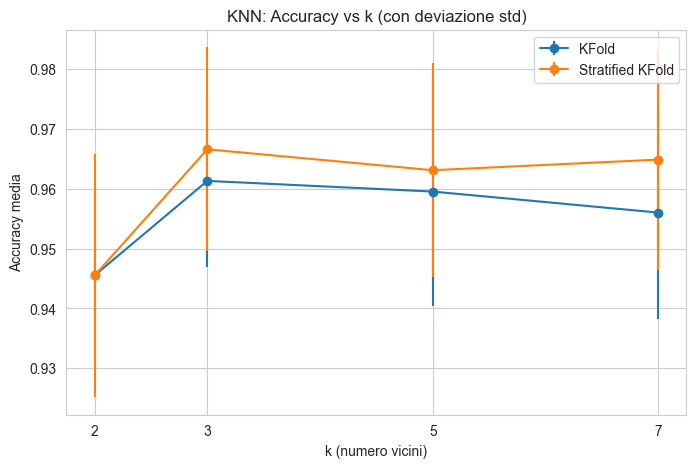

In [50]:
plt.figure(figsize=(8,5))

plt.errorbar(df_knn["k"], df_knn["KF_mean"], yerr=df_knn["KF_std"], label="KFold", marker='o')
plt.errorbar(df_knn["k"], df_knn["SKF_mean"], yerr=df_knn["SKF_std"], label="Stratified KFold", marker='o')

plt.title("KNN: Accuracy vs k (con deviazione std)")
plt.xlabel("k (numero vicini)")
plt.ylabel("Accuracy media")

plt.xticks(k_values)

plt.legend()
plt.show()

# XGBOOST

'n_estimators' (n) è il numero totale di alberi (decision tree) che XGBoost costruisce:
- Pochi alberi -> modello semplice, rischio underfitting
- Troppi alberi -> modello potente, rischio overfitting

'max_depth' (d) è la profondità massima di ogni albero:
- max_depth = 2 -> alberi superficiali, modello semplice
- max_depth = 5 -> alberi profondi, modello più complesso
- max_depth = 10 -> alberi molto complessi (rischio overfitting)

In [51]:
# Lista di combinazioni di iperparametri da testare: genera automaticamente tutte le combinazioni
xgb_params = [
    {"n_estimators": n, "max_depth": d}
    for n in [50, 100, 200]
    for d in [3, 5, 7]
]

xgb_results = []

for params in xgb_params:
    xgb = XGBClassifier(eval_metric='logloss', n_estimators=params["n_estimators"], max_depth=params["max_depth"], random_state=42)
    
    # KFold
    xgb_kf_mean, xgb_kf_std, xgb_kf_mse, xgb_kf_rmse = evaluate_model(xgb, X, y, kf)
    
    # StratifiedKFold
    xgb_skf_mean, xgb_skf_std, xgb_skf_mse, xgb_skf_rmse = evaluate_model(xgb, X, y, skf)
    
    xgb_results.append({
        "n_estimators": params["n_estimators"],
        "max_depth": params["max_depth"],
        "KF_mean": xgb_kf_mean,
        "KF_std": xgb_kf_std,
        "KF_MSE": xgb_kf_mse,
        "KF_RMSE": xgb_kf_rmse,
        "SKF_mean": xgb_skf_mean,
        "SKF_std": xgb_skf_std,
        "SKF_MSE": xgb_skf_mse,
        "SKF_RMSE": xgb_skf_rmse
    })

df_xgb = pd.DataFrame(xgb_results)
print("\nRisultati XGBoost (cross-validation):")
display(df_xgb.style.hide(axis="index"))


Risultati XGBoost (cross-validation):


n_estimators,max_depth,KF_mean,KF_std,KF_MSE,KF_RMSE,SKF_mean,SKF_std,SKF_MSE,SKF_RMSE
50,3,0.968359,0.011918,0.031641,0.177879,0.961341,0.018051,0.038659,0.196618
50,5,0.964835,0.015736,0.035165,0.187524,0.963080,0.010284,0.036920,0.192145
50,7,0.964835,0.015736,0.035165,0.187524,0.957848,0.010158,0.042152,0.205309
100,3,0.968359,0.011918,0.031641,0.177879,0.963096,0.017003,0.036904,0.192105
100,5,0.964835,0.015736,0.035165,0.187524,0.964835,0.009681,0.035165,0.187524
100,7,0.964835,0.015736,0.035165,0.187524,0.952554,0.008916,0.047446,0.217821
200,3,0.963096,0.006549,0.036904,0.192105,0.964850,0.016644,0.035150,0.187483
200,5,0.966589,0.017058,0.033411,0.182787,0.964819,0.020085,0.035181,0.187566
200,7,0.964835,0.015736,0.035165,0.187524,0.954293,0.010295,0.045707,0.213792


# TABELLA DI CONFRONTO FINALE

## Logistic Regression

In [52]:
summary = []

summary.append({
    "model": "LogisticRegression",
    "setting": "KFold",
    "mean_acc": log_kf_mean,
    "std_acc": log_kf_std,
    "MSE": log_kf_mse,
    "RMSE": log_kf_rmse
})

summary.append({
    "model": "LogisticRegression",
    "setting": "StratifiedKFold",
    "mean_acc": log_skf_mean,
    "std_acc": log_skf_std,
    "MSE": log_skf_mse,
    "RMSE": log_skf_rmse
})

## KNN per ogni k

In [53]:
for row in knn_results:
    summary.append({
        "model": f"KNN (k={row['k']})",
        "setting": "KFold",
        "mean_acc": row["KF_mean"],
        "std_acc": row["KF_std"],
        "MSE": row["KF_MSE"],
        "RMSE": row["KF_RMSE"]
    })
    
    summary.append({
        "model": f"KNN (k={row['k']})",
        "setting": "StratifiedKFold",
        "mean_acc": row["SKF_mean"],
        "std_acc": row["SKF_std"],
        "MSE": row["SKF_MSE"],
        "RMSE": row["SKF_RMSE"]
    })

## Xgboost

In [54]:
for _, row in df_xgb.iterrows():
    summary.append({
        "model": f"XGBoost (n={row['n_estimators']}, d={row['max_depth']})",
        "setting": "KFold",
        "mean_acc": row["KF_mean"],
        "std_acc": row["KF_std"],
        "MSE": row["KF_MSE"],
        "RMSE": row["KF_RMSE"]
    })
    
    summary.append({
        "model": f"XGBoost (n={row['n_estimators']}, d={row['max_depth']})",
        "setting": "StratifiedKFold",
        "mean_acc": row["SKF_mean"],
        "std_acc": row["SKF_std"],
        "MSE": row["SKF_MSE"],
        "RMSE": row["SKF_RMSE"]
    })

In [55]:
df_summary = pd.DataFrame(summary)
print("\nTabella confronto finale (CV)")
display(df_summary.style.hide(axis="index"))


Tabella confronto finale (CV)


model,setting,mean_acc,std_acc,MSE,RMSE
LogisticRegression,KFold,0.977146,0.008964,0.022854,0.151174
LogisticRegression,StratifiedKFold,0.973669,0.016627,0.026331,0.162269
KNN (k=2),KFold,0.945505,0.014091,0.054495,0.233441
KNN (k=2),StratifiedKFold,0.945505,0.020347,0.054495,0.233441
KNN (k=3),KFold,0.961310,0.014345,0.038690,0.196697
KNN (k=3),StratifiedKFold,0.966589,0.017058,0.033411,0.182787
KNN (k=5),KFold,0.959525,0.019092,0.040475,0.201184
KNN (k=5),StratifiedKFold,0.963096,0.017886,0.036904,0.192105
KNN (k=7),KFold,0.956016,0.017731,0.043984,0.209723
KNN (k=7),StratifiedKFold,0.964866,0.018378,0.035134,0.187441


# MODELLO MIGLIORE: 'accuracy' (più alta) COMBINATO CON 'rmse' (più bassa)

In [57]:
df_summary["rank_acc"] = df_summary["mean_acc"].rank(ascending=False)
df_summary["rank_rmse"] = df_summary["RMSE"].rank(ascending=True)

df_summary["final_score"] = df_summary["rank_acc"] + df_summary["rank_rmse"]

sorted_combined = df_summary.sort_values(by="final_score", ascending=True)

print("MODELLI ORDINATI PER MIGLIORE PUNTEGGIO COMBINATO (Accuracy + RMSE)")
display(sorted_combined.style.hide(axis="index"))

MODELLI ORDINATI PER MIGLIORE PUNTEGGIO COMBINATO (Accuracy + RMSE)


model,setting,mean_acc,std_acc,MSE,RMSE,rank_acc,rank_rmse,final_score
LogisticRegression,KFold,0.977146,0.008964,0.022854,0.151174,1.000000,1.000000,2.000000
LogisticRegression,StratifiedKFold,0.973669,0.016627,0.026331,0.162269,2.000000,2.000000,4.000000
"XGBoost (n=100.0, d=3.0)",KFold,0.968359,0.011918,0.031641,0.177879,3.500000,3.500000,7.000000
"XGBoost (n=50.0, d=3.0)",KFold,0.968359,0.011918,0.031641,0.177879,3.500000,3.500000,7.000000
"XGBoost (n=200.0, d=5.0)",KFold,0.966589,0.017058,0.033411,0.182787,5.500000,5.500000,11.000000
KNN (k=3),StratifiedKFold,0.966589,0.017058,0.033411,0.182787,5.500000,5.500000,11.000000
KNN (k=7),StratifiedKFold,0.964866,0.018378,0.035134,0.187441,7.000000,7.000000,14.000000
"XGBoost (n=200.0, d=3.0)",StratifiedKFold,0.964850,0.016644,0.035150,0.187483,8.000000,8.000000,16.000000
"XGBoost (n=100.0, d=5.0)",KFold,0.964835,0.015736,0.035165,0.187524,11.500000,11.500000,23.000000
"XGBoost (n=50.0, d=7.0)",KFold,0.964835,0.015736,0.035165,0.187524,11.500000,11.500000,23.000000
